# Run Chime model with reading parameters from SAP HANA and write results in SAP HANA
## Notebook aims to allow ease of access to model and results for later analysis
## All license and credit goes to Chime team

## Last tested Chime release v1.1.2
[Chime App](https://penn-chime.phl.io/) [Chime Github release](https://github.com/CodeForPhilly/chime/releases/tag/v1.1.0)
---
---
SAP HANA Python Client API for Machine Learning Algorithms:   
---
[HANA ML on Pypi](https://pypi.org/project/hana-ml/) [1.0.8](https://help.sap.com/doc/1d0ebfe5e8dd44d09606814d83308d4b/2.0.04/en-US/index.html)
---
Other useful Links:
----
[Chime helper/scenario runnner](https://github.com/misken/c19/tree/master/mychime)

[Covid Staffing](http://www.covidstaffing.org/)

[Imperial College Covid-19 Model](https://github.com/ImperialCollegeLondon/covid19model)

[IHME](https://covid19.healthdata.org/projections)

@Author nidhi.sawhney@sap.com

In [1]:
from utils import *
from parameters import *
from models import *
from settings import DEFAULTS
import sys


import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
print(sys.version)

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


#### Connect to HANA to retrieve paramters

In [2]:
import hana_ml
from hana_ml import dataframe
import configparser
settings = configparser.ConfigParser()
config_file = open("config/hana_ml.ini")
settings.readfp(config_file)
settings.sections()
url = settings.get("HANA","url")
port = settings.get("HANA", "port")
user = settings.get("HANA","user")
pwd = settings.get("HANA","passwd")
cnxn = dataframe.ConnectionContext("{}".format(url),int("{}".format(port)), "{}".format(user), "{}".format(pwd), encrypt="true")
print(hana_ml.__version__)

1.0.8


In [3]:
parameters = cnxn.table("HDI_TBL_DEFAULT_PARAMETERS",schema="CHIME_DB_1")
parameters.collect()

,population,current_hospitalized,doubling_time,known_infected,n_days,market_share,relative_contact_rate,hospitalized_rate,hospitalized_los,icu_rate,icu_los,ventilated_rate,ventilated_los
0,3600000,69,4,510,100,0.15,0.3,0.025,7,0.0075,9,0.005,10


In [4]:

p = Parameters(current_hospitalized=parameters.head(1).select(["current_hospitalized"]).collect().to_numpy()[0][0],
        doubling_time=parameters.head(1).select(["doubling_time"]).collect().to_numpy()[0][0],
        relative_contact_rate=parameters.head(1).select(["relative_contact_rate"]).collect().to_numpy()[0][0],
        population=parameters.head(1).select(["population"]).collect().to_numpy()[0][0],
        hospitalized=Disposition(parameters.head(1).select(["hospitalized_rate"]).collect().to_numpy()[0][0],parameters.head(1).select(["hospitalized_los"]).collect().to_numpy()[0][0]),
        icu=Disposition(parameters.head(1).select(["icu_rate"]).collect().to_numpy()[0][0],parameters.head(1).select(["icu_los"]).collect().to_numpy()[0][0]),
        ventilated=Disposition(parameters.head(1).select(["ventilated_rate"]).collect().to_numpy()[0][0],parameters.head(1).select(["ventilated_los"]).collect().to_numpy()[0][0]),
        date_first_hospitalized = None,
        n_days = parameters.head(1).select(["n_days"]).collect().to_numpy()[0][0],
        market_share = parameters.head(1).select(["market_share"]).collect().to_numpy()[0][0])


In [5]:

m = SimSirModel(p)

2020-04-07 12:31:52,383 - models - INFO - Using doubling_time: 4
2020-04-07 12:31:52,426 - models - INFO - Set i_day = 25
2020-04-07 12:31:52,426 - models - INFO - Estimated date_first_hospitalized: 2020-03-13; current_date: 2020-04-07; i_day: 25
2020-04-07 12:31:52,427 - models - INFO - len(np.arange(-i_day, n_days+1)): 126
2020-04-07 12:31:52,427 - models - INFO - len(raw_df): 126


In [6]:
m.raw_df

,day,susceptible,infected,recovered
0,-25,3.599733e+06,266.666667,0.000000e+00
1,-24,3.599664e+06,317.121897,1.904762e+01
2,-23,3.599581e+06,377.122021,4.169918e+01
3,-22,3.599483e+06,448.472036,6.863647e+01
4,-21,3.599366e+06,533.318004,1.006702e+02
5,-20,3.599227e+06,634.211381,1.387643e+02
6,-19,3.599062e+06,754.185437,1.840651e+02
7,-18,3.598865e+06,896.846015,2.379355e+02
8,-17,3.598632e+06,1066.479290,3.019960e+02
9,-16,3.598354e+06,1268.179681,3.781731e+02


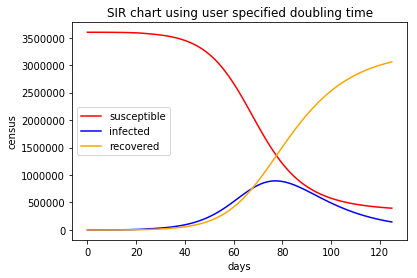

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.array(m.census_df.index)

chime_y_fd_s = np.array(m.raw_df['susceptible'])[:len(x)]
chime_y_fd_i = np.array(m.raw_df['infected'])[:len(x)]
chime_y_fd_r = np.array(m.raw_df['recovered'])[:len(x)]

plt.plot(x, chime_y_fd_s, 'r-', label = 'susceptible')
plt.plot(x, chime_y_fd_i, color='blue', label = 'infected')
plt.plot(x, chime_y_fd_r, color='orange', label = 'recovered')
plt.title('SIR chart using user specified doubling time')
plt.xlabel('days')
plt.ylabel('census')
plt.legend()

plt.show()

In [8]:
m.admits_df

,day,date,hospitalized,icu,ventilated
0,-25,2020-03-13,NaN,NaN,NaN
1,-24,2020-03-14,0.260636,0.078191,0.052127
2,-23,2020-03-15,0.309944,0.092983,0.061989
3,-22,2020-03-16,0.368577,0.110573,0.073715
4,-21,2020-03-17,0.438299,0.131490,0.087660
5,-20,2020-03-18,0.521203,0.156361,0.104241
6,-19,2020-03-19,0.619781,0.185934,0.123956
7,-18,2020-03-20,0.736991,0.221097,0.147398
8,-17,2020-03-21,0.876351,0.262905,0.175270
9,-16,2020-03-22,1.042041,0.312612,0.208408


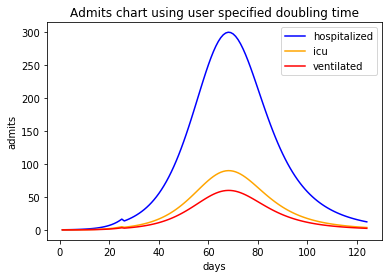

In [14]:
#import matplotlib.pyplot as plt
#%matplotlib inline

x = np.array(m.admits_df.index)

chime_y_fd_h = np.array(m.admits_df['hospitalized'])[:len(x)]
chime_y_fd_i = np.array(m.admits_df['icu'])[:len(x)]
chime_y_fd_v = np.array(m.admits_df['ventilated'])[:len(x)]

plt.plot(x, chime_y_fd_h, 'b-', label = 'hospitalized')
plt.plot(x, chime_y_fd_i, color='orange', label = 'icu')
plt.plot(x, chime_y_fd_v, 'r-', label = 'ventilated')


plt.title('Admits chart using user specified doubling time')
plt.xlabel('days')
plt.ylabel('admits')
plt.legend()

plt.show()

In [10]:
m.census_df

,day,date,hospitalized,icu,ventilated
0,-25,2020-03-13,NaN,NaN,NaN
1,-24,2020-03-14,1.0,1.0,1.0
2,-23,2020-03-15,1.0,1.0,1.0
3,-22,2020-03-16,1.0,1.0,1.0
4,-21,2020-03-17,2.0,1.0,1.0
5,-20,2020-03-18,2.0,1.0,1.0
6,-19,2020-03-19,3.0,1.0,1.0
7,-18,2020-03-20,4.0,1.0,1.0
8,-17,2020-03-21,4.0,2.0,1.0
9,-16,2020-03-22,5.0,2.0,2.0


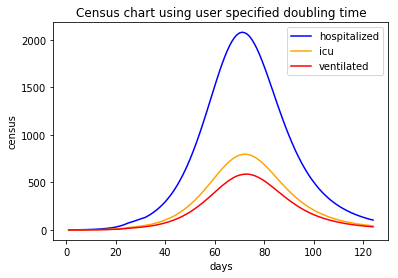

In [11]:
#import matplotlib.pyplot as plt
#%matplotlib inline

x = np.array(m.census_df.index)

chime_y_fd_h = np.array(m.census_df['hospitalized'])[:len(x)]
chime_y_fd_i = np.array(m.census_df['icu'])[:len(x)]
chime_y_fd_v = np.array(m.census_df['ventilated'])[:len(x)]

plt.plot(x, chime_y_fd_h, 'b-', label = 'hospitalized')
plt.plot(x, chime_y_fd_i, color='orange', label = 'icu')
plt.plot(x, chime_y_fd_v, 'r-', label = 'ventilated')
plt.title('Census chart using user specified doubling time')
plt.xlabel('days')
plt.ylabel('census')
plt.legend()

plt.show()

## Save the results in SAP HANA
### Change datetime to date only to save in HANA

In [12]:
m.admits_df['date'] = m.admits_df['date'].dt.date
m.census_df['date'] = m.census_df['date'].dt.date


### Save dataframe to HANA

In [13]:
dataframe.create_dataframe_from_pandas(cnxn, m.admits_df, table_name="ADMITS",schema="CHIME", force=True, replace=False)
dataframe.create_dataframe_from_pandas(cnxn, m.census_df, table_name="CENSUS",schema="CHIME", force=True, replace=False)